In [1]:
from typing import Tuple, List, Iterable
from pydot import Dot, graph_from_dot_data, Edge
from graphviz.graphs import BaseGraph
from graphviz import Source
import amrlib
from amrlib.graph_processing.amr_plot import AMRPlot
import numpy as np
import pandas as pd 

In [2]:
def get_graph_dot_obj(graph_spec) -> List[Dot]:
    """Get a dot (graphs) object list from a variety 
    of possible sources (postelizing inputs here)"""
    _original_graph_spec = graph_spec
    if isinstance(graph_spec, (BaseGraph, Source)):
        # get the source (str) from a graph object
        graph_spec = graph_spec.source
    if isinstance(graph_spec, str):
        # get a dot-graph from dot string data
        graph_spec = graph_from_dot_data(graph_spec)
    # make sure we have a list of Dot objects now
    assert isinstance(graph_spec, list) and all(
        isinstance(x, Dot) for x in graph_spec
    ), (
        f"Couldn't get a proper dot object list from: {_original_graph_spec}. "
        f"At this point, we should have a list of Dot objects, but was: {graph_spec}"
    )
    return graph_spec

def get_edges(graph_spec, label = False):
    """Get a list of edges for a given graph (or list of lists thereof).
    If ``postprocess_edges`` is ``None`` the function will return ``pydot.Edge`` objects from
    which you can extract any information you want.
    By default though, it is set to extract the node pairs for the edges, and you can
    replace with any function that takes ``pydot.Edge`` as an input.
    """
    graphs = get_graph_dot_obj(graph_spec)
    n_graphs = len(graphs)

    if n_graphs > 1:
        return [get_edges(graph) for graph in graphs]
    elif n_graphs == 0:
        raise ValueError(f"Your input had no graphs")
    else:
        graph = graphs[0]
        edges = graph.get_edges()
        edges_list = []
        
        if not label:
            for edge in edges:
                edges_list.append((graph.get_node(edge.get_source())[0].get_label(),
                                   graph.get_node(edge.get_destination())[0].get_label()))
        else:
            for edge in edges:
                edges_list.append((graph.get_node(edge.get_source())[0].get_label(),
                                   graph.get_node(edge.get_destination())[0].get_label(),
                                   edge.get_label() ))

        return edges_list

    
    
#cite: https://stackoverflow.com/questions/47426249/finding-list-of-edges-in-graphviz-in-python    

In [3]:
stog = amrlib.load_stog_model()
graph = stog.parse_sents(['This is a test of the system'], add_metadata = False)


In [4]:
print(graph[0])

(t / test-01
      :ARG1 (s / system)
      :domain (t2 / this))


In [5]:
AP = AMRPlot()
AP.build_from_graph(entry = graph)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


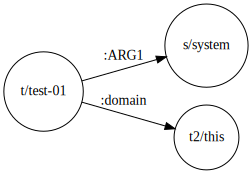

In [6]:
AP.graph

In [7]:
edges = tuple(get_edges(AP.graph))
edges

(('"t/test-01"', '"s/system"'), ('"t/test-01"', '"t2/this"'))

In [8]:
edges_with_labels  = tuple(get_edges(AP.graph, label = True))
edges_with_labels

(('"t/test-01"', '"s/system"', '":ARG1"'),
 ('"t/test-01"', '"t2/this"', '":domain"'))

## Adjacency matrix (n*m)
### n is the number of source words, m is the number of target words

In [9]:
sources = list(set([i for i, j, l in edges_with_labels]))
targets = list(set([j for i, j, l in edges_with_labels]))
labels = list(set([l for i, j, l in edges_with_labels]))
adj_matrix = np.zeros((len(sources),len(targets)))

for i, j, l in edges_with_labels:
    s = sources.index(i)
    t = targets.index(j)
    adj_matrix[s][t] = 1

In [10]:
df1 = pd.DataFrame(data = adj_matrix, index = sources , columns = targets)

In [11]:
df1

,"""s/system""","""t2/this"""
"""t/test-01""",1.0,1.0


## Adjacency matrix (n*n)
### n is the number of words

In [12]:
node_names2, adj_idx2 = np.unique(edges, return_inverse=True)
adj_idx2 = adj_idx2.reshape(-1, 2)
adj_matrix2 = np.zeros((len(node_names2),)*2)
adj_matrix2[adj_idx2[:, 0], adj_idx2[:, 1]] = 1
adj_matrix2
#cite: https://stackoverflow.com/questions/21324774/convert-non-numeric-tuples-to-numpy-matrix

array([[0., 0., 0.],
       [1., 0., 1.],
       [0., 0., 0.]])

In [13]:
df2 = pd.DataFrame(data = adj_matrix2, index = node_names2 , columns = node_names2)
df2

,"""s/system""","""t/test-01""","""t2/this"""
"""s/system""",0.0,0.0,0.0
"""t/test-01""",1.0,0.0,1.0
"""t2/this""",0.0,0.0,0.0
